In [7]:
import pathlib
from typing import Union, List

import numpy as np
from matplotlib import pyplot as plt

from qec_util.layouts import Layout, plot, set_coords

from surface_sim import Setup
from surface_sim.models import CircuitNoiseModel
from surface_sim.experiments import memory_exp
from surface_sim.util import sample_experiment

In [8]:
EXP_DIR : str = pathlib.Path.cwd()

CONFIG_DIR = EXP_DIR / "config"
if not CONFIG_DIR.exists():
    raise ValueError("Layout directory does not exist.")

In [9]:
LAYOUT_FILE = "d3_rotated_layout.yaml"
SETUP_FILE = "var_circ_depolarization.yaml"

layout = Layout.from_yaml(CONFIG_DIR / LAYOUT_FILE)
set_coords(layout)
setup = Setup.from_yaml(CONFIG_DIR / SETUP_FILE)
model = CircuitNoiseModel(setup, layout)

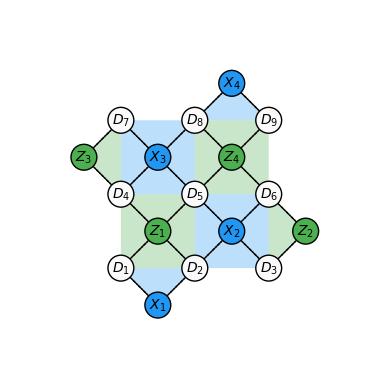

In [11]:
fig, ax = plt.subplots()
_ = plot(layout, axis=ax)
plt.show()

# Generate the training data

In [8]:
DATASET_TYPE : str = "test" # Possible types are "train", "dev" and "test"

# Fixed parameters
ROOT_SEED : Union[int, None] = np.random.randint(999999) # Initial seed for the RNG
LIST_NUM_ROUNDS : List[int] = list(range(1, 20 + 1, 2)) # Number of rounds
NUM_SHOTS : int = 20000 # Number of shots
ROT_BASIS : bool = False  # In the z-basis
MEAS_RESET : bool = False # No resets following measurements

# Variable parameters
LOG_STATES : List[int] = [0, 1] # Logical state(s)
DEPOL_PROB : Union[float, List[float]] = 1e-3

In [9]:
global_seed_sequence = np.random.SeedSequence(ROOT_SEED)
global_seeds = iter(global_seed_sequence.generate_state(len(LIST_NUM_ROUNDS), dtype="uint64"))

model.setup.set_var_param("prob", DEPOL_PROB)

for NUM_ROUNDS in LIST_NUM_ROUNDS:
    print(NUM_ROUNDS, end="\r")
    NUM_ROUNDS = int(NUM_ROUNDS) # make sure it is an int, not np.int32

    basis = "X" if ROT_BASIS else "Z"
    seed_sequence = np.random.SeedSequence(ROOT_SEED)

    num_experiments = len(LOG_STATES)
    global_seed = next(global_seeds)
    seed_sequence = np.random.SeedSequence(global_seed)
    seeds = iter(seed_sequence.generate_state(num_experiments, dtype="uint64"))

    for log_state in LOG_STATES:
        exp_name = f"surf-code_d{layout.distance}_b{basis}_s{log_state}_n{NUM_SHOTS}_r{NUM_ROUNDS}"

        exp_folder = EXP_DIR / DATASET_TYPE / exp_name
        exp_folder.mkdir(parents=True, exist_ok=True)

        experiment = memory_exp(
            model=model,
            num_rounds=NUM_ROUNDS,
            log_state=log_state,
            rot_basis=ROT_BASIS,
            meas_reset=MEAS_RESET,
        )

        experiment.to_file(exp_folder / "circuit.stim")

        seed = next(seeds)
        dataset = sample_experiment(
            layout,
            experiment,
            seed=seed,
            num_shots=NUM_SHOTS,
            num_rounds=NUM_ROUNDS,
        )

        # assign these as coordinate for merging datasets later on. Add here any otther relevant parameters
        dataset = dataset.assign_coords(
            log_state=log_state,
            rot_basis=int(ROT_BASIS),
            meas_reset=int(MEAS_RESET),
        )
        dataset.attrs["root_seed"] = ROOT_SEED

        dataset.to_netcdf(exp_folder / "measurements.nc")

        error_model = experiment.detector_error_model(
            decompose_errors=True,
            allow_gauge_detectors=True,
        )
        error_model.to_file(exp_folder / "detector_error_model.dem")


In [16]:
layout._set_coords()

In [20]:
layout.graph.nodes["D1"]

{'role': 'data', 'coords': (-3, -3), 'stab_type': None, 'freq_group': 'low'}